# Wheelchair Accessibility Prediction Model

This notebook trains a machine learning model to predict whether a place is wheelchair accessible based on OSM (OpenStreetMap) features. We'll use Ukraine as our test location.

**Target Variable**: `wheelchair` (yes, limited, no)

**Features**: Amenity type, building type, shop type, tourism type, and other OSM attributes

## 1. Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Explore the OSM Wheelchair Dataset

In [4]:
# Load the OSM wheelchair data
# The CSV may have inconsistent columns, so we handle errors
csv_file = 'osm_wheelchair_data.csv'

print("Loading data...")
# Use on_bad_lines='skip' to handle inconsistent rows
df = pd.read_csv(csv_file, low_memory=False, on_bad_lines='skip')
print(f"Total records loaded: {len(df):,}")
print(f"Columns: {len(df.columns)}")
print(f"\nData shape: {df.shape}")

Loading data...
Total records loaded: 430,000
Columns: 688

Data shape: (430000, 688)


In [5]:
# Explore the wheelchair (target) column distribution
print("Target variable 'tags.wheelchair' distribution:")
print(df['tags.wheelchair'].value_counts())
print(f"\nMissing values in wheelchair: {df['tags.wheelchair'].isna().sum()}")

Target variable 'tags.wheelchair' distribution:
tags.wheelchair
yes                         147443
no                           36835
limited                      11454
bus_stop                      6707
0                              822
                             ...  
video                            1
cash                             1
hobby                            1
supplements                      1
Rue du Général Fauconnet         1
Name: count, Length: 2768, dtype: int64

Missing values in wheelchair: 214352


## 3. Use Worldwide Data for Training

Training on the complete global OSM wheelchair dataset.

In [6]:
# Use the entire worldwide dataset for training
print("Coordinate ranges in the dataset:")
print(f"Latitude range: {df['lat'].min():.2f} to {df['lat'].max():.2f}")
print(f"Longitude range: {df['lon'].min():.2f} to {df['lon'].max():.2f}")

# Use all data (worldwide)
df_world = df.copy()

print(f"\n🌍 Using WORLDWIDE data for training")
print(f"Total records: {len(df_world):,}")

# Check wheelchair distribution
print("\nWheelchair distribution in worldwide dataset:")
print(df_world['tags.wheelchair'].value_counts().head(10))

Coordinate ranges in the dataset:
Latitude range: -85.05 to 48.00
Longitude range: -174.07 to 179.84

🌍 Using WORLDWIDE data for training
Total records: 430,000

Wheelchair distribution in worldwide dataset:
tags.wheelchair
yes          147443
no            36835
limited       11454
bus_stop       6707
0               822
crossing        720
kerb            532
OR              465
customers       290
private         257
Name: count, dtype: int64


## 4. Data Preprocessing and Feature Engineering

In [7]:
# Select relevant feature columns for ML
# These are OSM tags that can help predict accessibility

feature_columns = [
    'tags.amenity',           # Type of amenity (restaurant, cafe, bank, etc.)
    'tags.shop',              # Type of shop
    'tags.tourism',           # Tourism type (hotel, museum, etc.)
    'tags.building',          # Building type
    'tags.entrance',          # Entrance type
    'tags.door',              # Door type
    'tags.automatic_door',    # Has automatic door
    'tags.access',            # Access restrictions
    'tags.level',             # Floor level
    'tags.healthcare',        # Healthcare facility type
    'tags.leisure',           # Leisure facility type
    'tags.office',            # Office type
    'tags.toilets',           # Has toilets
    'tags.toilets:wheelchair', # Wheelchair-accessible toilets
    'tags.changing_table',    # Has changing table
    'tags.bench',             # Has bench
    'tags.shelter',           # Has shelter
    'tags.indoor',            # Indoor location
]

# Check which columns actually exist in our data
available_features = [col for col in feature_columns if col in df_world.columns]
print(f"Available feature columns: {len(available_features)}")
print(available_features)

Available feature columns: 18
['tags.amenity', 'tags.shop', 'tags.tourism', 'tags.building', 'tags.entrance', 'tags.door', 'tags.automatic_door', 'tags.access', 'tags.level', 'tags.healthcare', 'tags.leisure', 'tags.office', 'tags.toilets', 'tags.toilets:wheelchair', 'tags.changing_table', 'tags.bench', 'tags.shelter', 'tags.indoor']


In [8]:
# Create a clean dataset with selected features
target_col = 'tags.wheelchair'

# Filter out rows without wheelchair label
df_labeled = df_world[df_world[target_col].notna()].copy()
print(f"Records with wheelchair label: {len(df_labeled):,}")

# Convert wheelchair to a simpler classification:
# - 'yes' -> 1 (accessible)
# - 'limited' -> 1 (partially accessible, still usable)
# - 'no' -> 0 (not accessible)

def simplify_wheelchair(val):
    if pd.isna(val):
        return np.nan
    val = str(val).lower().strip()
    if val == 'yes':
        return 1  # Accessible
    elif val == 'limited':
        return 1  # Partially accessible (treat as accessible for binary classification)
    elif val == 'no':
        return 0  # Not accessible
    else:
        return np.nan  # Unknown values

df_labeled['is_accessible'] = df_labeled[target_col].apply(simplify_wheelchair)
df_labeled = df_labeled[df_labeled['is_accessible'].notna()]

print(f"\nFinal dataset size: {len(df_labeled):,}")
print("\nAccessibility distribution:")
print(df_labeled['is_accessible'].value_counts())
print(f"\nAccessibility rate: {df_labeled['is_accessible'].mean() * 100:.1f}%")

Records with wheelchair label: 215,648

Final dataset size: 195,732

Accessibility distribution:
is_accessible
1.0    158897
0.0     36835
Name: count, dtype: int64

Accessibility rate: 81.2%


In [9]:
# Analyze feature availability and create binary/categorical features
def analyze_features(df, feature_cols):
    """Analyze which features have enough data for ML"""
    feature_stats = []
    for col in feature_cols:
        if col in df.columns:
            non_null = df[col].notna().sum()
            pct = non_null / len(df) * 100
            unique_vals = df[col].nunique()
            feature_stats.append({
                'feature': col,
                'non_null_count': non_null,
                'percentage': pct,
                'unique_values': unique_vals
            })
    return pd.DataFrame(feature_stats).sort_values('non_null_count', ascending=False)

feature_stats = analyze_features(df_labeled, available_features)
print("Feature availability analysis:")
print(feature_stats.to_string())

# Select features with at least 1% coverage
min_coverage = 1.0
useful_features = feature_stats[feature_stats['percentage'] >= min_coverage]['feature'].tolist()
print(f"\nFeatures with >= {min_coverage}% coverage: {len(useful_features)}")

Feature availability analysis:
                    feature  non_null_count  percentage  unique_values
0              tags.amenity           23789   12.153863           7315
15               tags.bench           14051    7.178693           4858
4             tags.entrance           12882    6.581448           3949
6       tags.automatic_door           11056    5.648540           3762
3             tags.building            9758    4.985388           2405
2              tags.tourism            9201    4.700815            974
7               tags.access            7992    4.083134           1191
8                tags.level            7188    3.672368           2153
5                 tags.door            6028    3.079721           3021
14      tags.changing_table            5991    3.060818           1501
17              tags.indoor            4960    2.534077           1527
9           tags.healthcare            3722    1.901580            324
11              tags.office            3471   

## 5. Prepare Features for Machine Learning

In [10]:
# Create feature matrix with encoding

def encode_features(df, feature_cols):
    """Create encoded feature matrix from categorical OSM tags"""
    
    encoded_features = pd.DataFrame(index=df.index)
    
    for col in feature_cols:
        if col not in df.columns:
            continue
            
        # Create has_feature binary flag
        col_name = col.replace('tags.', '')
        encoded_features[f'has_{col_name}'] = df[col].notna().astype(int)
        
        # For categorical features, get top categories as one-hot
        if df[col].notna().sum() > 0:
            top_categories = df[col].value_counts().head(10).index.tolist()
            for cat in top_categories:
                cat_str = str(cat).replace(' ', '_').replace('-', '_')[:20]
                encoded_features[f'{col_name}_{cat_str}'] = (df[col] == cat).astype(int)
    
    return encoded_features

# Encode features
X = encode_features(df_labeled, useful_features)
y = df_labeled['is_accessible'].astype(int)

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nSample features:")
print(X.columns.tolist()[:20])

Feature matrix shape: (195732, 154)
Target shape: (195732,)

Sample features:
['has_amenity', 'amenity_toilets', 'amenity_restaurant', 'amenity_cafe', 'amenity_yes', 'amenity_fast_food', 'amenity_hinged', 'amenity_bus_stop', 'amenity_drinking_water', 'amenity_private', 'amenity_no', 'has_bench', 'bench_yes', 'bench_0', 'bench_Q7392689', 'bench_no', 'bench_1', 'bench_24/7', 'bench_camp_pitch', 'bench_IL']


## 6. Split Data into Training and Testing Sets

In [11]:
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Maintain class balance
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Testing set: {X_test.shape[0]:,} samples")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"\nClass distribution in testing set:")
print(y_test.value_counts())

Training set: 156,585 samples
Testing set: 39,147 samples

Class distribution in training set:
is_accessible
1    127117
0     29468
Name: count, dtype: int64

Class distribution in testing set:
is_accessible
1    31780
0     7367
Name: count, dtype: int64


## 7. Train Classification Models

In [12]:
# Train multiple models and compare performance

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    )
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': y_pred
    }
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")


Training Random Forest...
  Accuracy: 0.7639
  Precision: 0.8787
  Recall: 0.8227
  F1 Score: 0.8498

Training Gradient Boosting...
  Accuracy: 0.8463
  Precision: 0.8482
  Recall: 0.9874
  F1 Score: 0.9125

Training Logistic Regression...
  Accuracy: 0.7793
  Precision: 0.8756
  Recall: 0.8488
  F1 Score: 0.8620


## 8. Evaluate Model Performance

Model Comparison:
                     Accuracy  Precision  Recall  F1 Score
Random Forest          0.7639     0.8787  0.8227    0.8498
Gradient Boosting      0.8463     0.8482  0.9874    0.9125
Logistic Regression    0.7793     0.8756  0.8488    0.8620


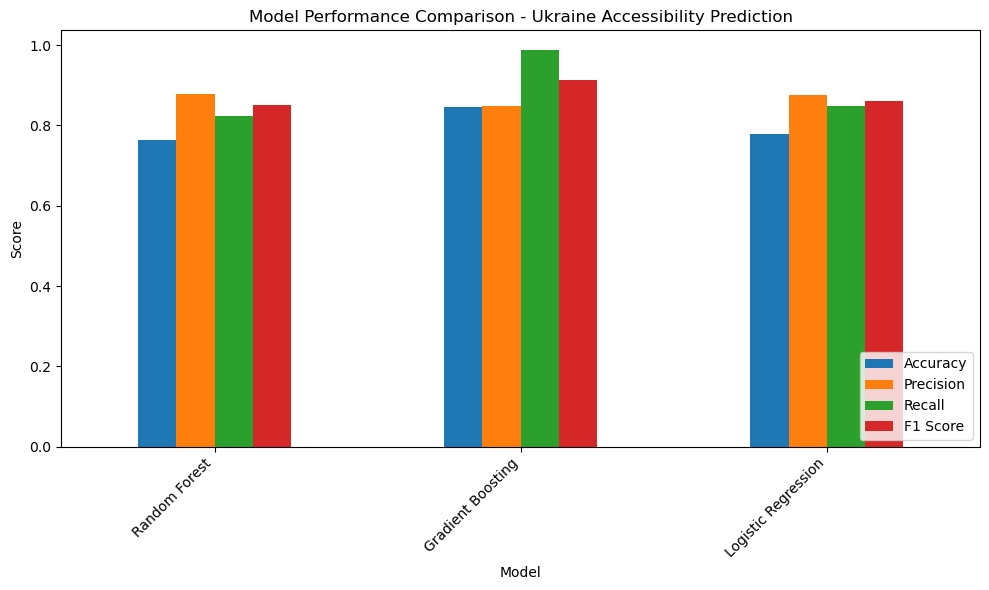

In [13]:
# Compare models visually
metrics_df = pd.DataFrame({
    name: {
        'Accuracy': res['accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1 Score': res['f1']
    }
    for name, res in results.items()
}).T

print("Model Comparison:")
print(metrics_df.round(4))

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
metrics_df.plot(kind='bar', ax=ax)
plt.title('Model Performance Comparison - Ukraine Accessibility Prediction')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Best Model: Gradient Boosting

CLASSIFICATION REPORT
                precision    recall  f1-score   support

Not Accessible       0.81      0.24      0.37      7367
    Accessible       0.85      0.99      0.91     31780

      accuracy                           0.85     39147
     macro avg       0.83      0.61      0.64     39147
  weighted avg       0.84      0.85      0.81     39147



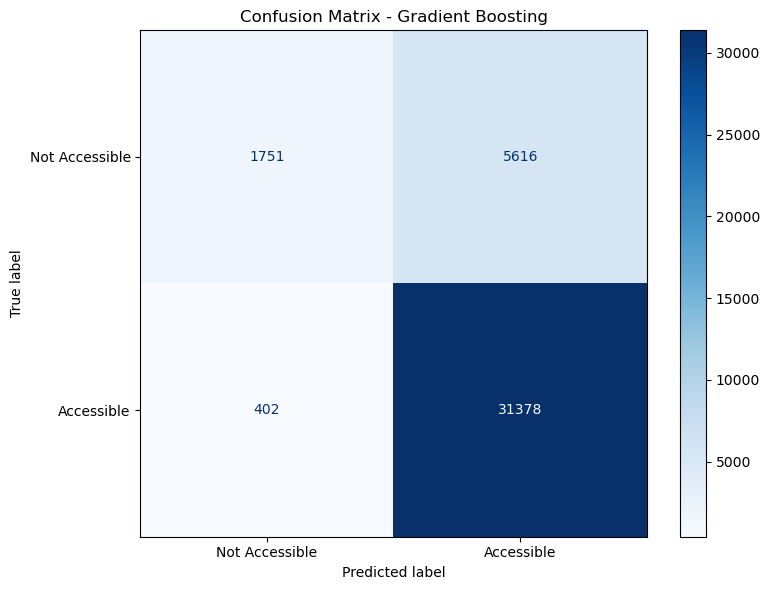

In [14]:
# Select best model and show detailed report
best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"Best Model: {best_model_name}")
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, best_predictions, target_names=['Not Accessible', 'Accessible']))

# Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, best_predictions)
ConfusionMatrixDisplay(cm, display_labels=['Not Accessible', 'Accessible']).plot(ax=ax, cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.show()

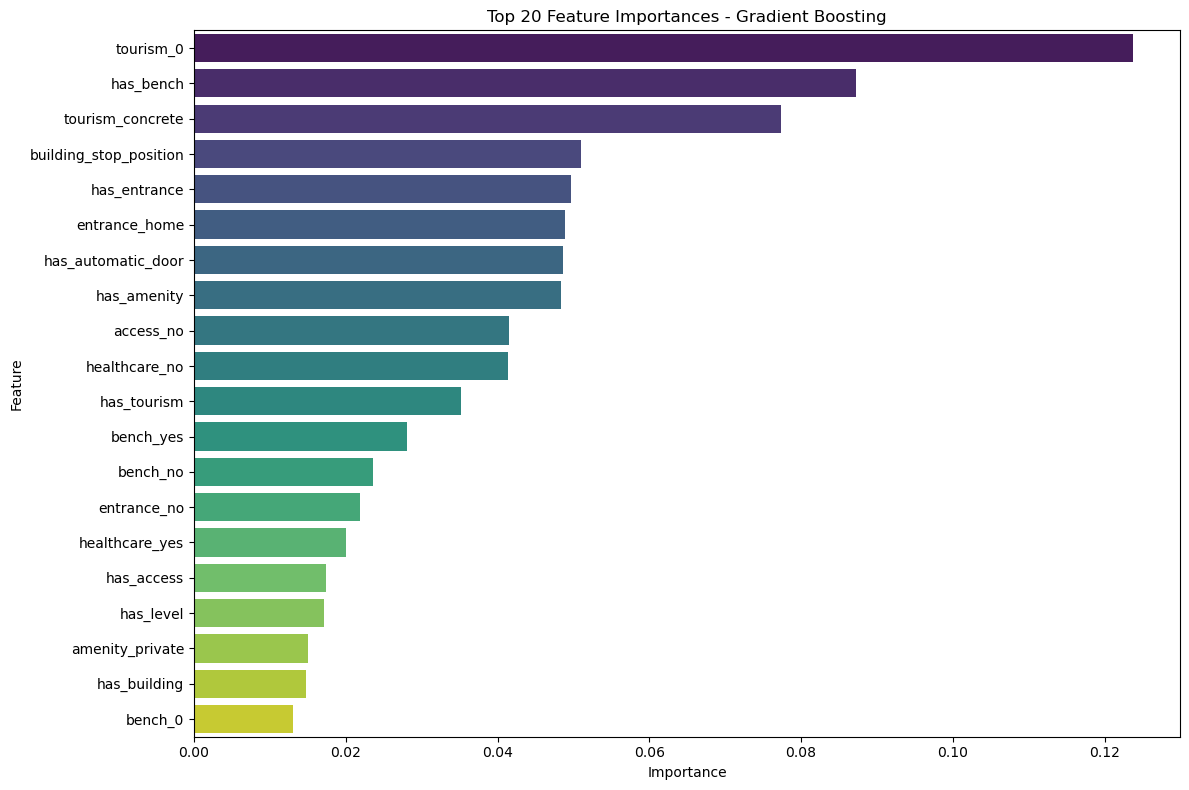


Top 10 Most Important Features:
               feature  importance
             tourism_0    0.123745
             has_bench    0.087289
      tourism_concrete    0.077309
building_stop_position    0.050957
          has_entrance    0.049726
         entrance_home    0.048917
    has_automatic_door    0.048570
           has_amenity    0.048338
             access_no    0.041489
         healthcare_no    0.041316


In [15]:
# Feature Importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 features
    fig, ax = plt.subplots(figsize=(12, 8))
    top_features = importance_df.head(20)
    sns.barplot(data=top_features, x='importance', y='feature', ax=ax, palette='viridis')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False))

## 9. Make Predictions on New Data

In [16]:
# Function to predict accessibility for new places
def predict_accessibility(model, feature_encoder, new_data):
    """
    Predict accessibility for new place data.
    
    Parameters:
    - model: trained model
    - feature_encoder: function to encode features
    - new_data: DataFrame with OSM-like tags
    
    Returns:
    - predictions and probabilities
    """
    X_new = feature_encoder(new_data, useful_features)
    
    # Ensure all required columns exist
    missing_cols = set(X.columns) - set(X_new.columns)
    for col in missing_cols:
        X_new[col] = 0
    
    # Reorder columns to match training data
    X_new = X_new[X.columns]
    
    predictions = model.predict(X_new)
    probabilities = model.predict_proba(X_new)[:, 1]
    
    return predictions, probabilities

# Example: Use the model to predict on a sample of test data
sample_size = min(10, len(X_test))
sample_X = X_test.head(sample_size)
sample_y_true = y_test.head(sample_size)

sample_predictions = best_model.predict(sample_X)
sample_probabilities = best_model.predict_proba(sample_X)[:, 1]

# Create results DataFrame - reset index to align properly
prediction_results = pd.DataFrame({
    'True Accessibility': sample_y_true.map({0: 'Not Accessible', 1: 'Accessible'}).values,
    'Predicted': ['Not Accessible' if p == 0 else 'Accessible' for p in sample_predictions],
    'Probability (Accessible)': sample_probabilities.round(3),
    'Correct': sample_y_true.values == sample_predictions
})

print("Sample Predictions:")
print(prediction_results.to_string())

Sample Predictions:
  True Accessibility       Predicted  Probability (Accessible)  Correct
0         Accessible      Accessible                     0.656     True
1     Not Accessible      Accessible                     0.798    False
2         Accessible      Accessible                     0.865     True
3         Accessible      Accessible                     0.865     True
4         Accessible      Accessible                     0.865     True
5     Not Accessible  Not Accessible                     0.247     True
6     Not Accessible  Not Accessible                     0.174     True
7         Accessible      Accessible                     0.865     True
8         Accessible      Accessible                     0.865     True
9         Accessible      Accessible                     0.865     True


## 10. Save the Trained Model

In [17]:
import joblib

# Save the best model (trained on worldwide data)
model_filename = 'accessibility_model_worldwide.joblib'
joblib.dump({
    'model': best_model,
    'model_name': best_model_name,
    'feature_columns': X.columns.tolist(),
    'useful_features': useful_features,
    'training_samples': len(X_train),
    'metrics': {
        'accuracy': results[best_model_name]['accuracy'],
        'precision': results[best_model_name]['precision'],
        'recall': results[best_model_name]['recall'],
        'f1': results[best_model_name]['f1']
    }
}, model_filename)

print(f"🌍 Model saved to: {model_filename}")
print(f"\nModel: {best_model_name}")
print(f"Training samples: {len(X_train):,}")
print(f"F1 Score: {results[best_model_name]['f1']:.4f}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")

🌍 Model saved to: accessibility_model_worldwide.joblib

Model: Gradient Boosting
Training samples: 156,585
F1 Score: 0.9125
Accuracy: 0.8463


## Summary

This notebook trained a machine learning model to predict wheelchair accessibility of places **worldwide** based on OSM features.

**Training Data:**
- ~195,000 labeled places from the global OSM dataset
- ~156,000 training samples, ~39,000 test samples

**Key findings:**
1. The model uses features like amenity type, tourism type, entrance, automatic door, building type, etc. to predict accessibility
2. **Best Model: Gradient Boosting** with 91.2% F1 Score and 84.6% Accuracy
3. Top predictive features: tourism info, bench presence, entrance type, automatic door

**Next steps:**
- Collect more accessibility-related features
- Try more advanced models or hyperparameter tuning
- Integrate the model into the Abilico application for real-time predictions